### Import Library

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from dataset import *
from models import *
from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, mIoU, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping, global_step_from_engine
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.param_scheduler import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

### Device

In [2]:
# Setup device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Acquisition

In [3]:
# Load dataset:
train_FD = [pd.read_csv(f"CMAPSS/train_FD00{i+1}.txt", sep=' ', header=None).iloc[:, :-2] for i in range(4)]
test_FD = [pd.read_csv(f"CMAPSS/test_FD00{i+1}.txt", sep=' ', header=None).iloc[:, :-2] for i in range(4)]
rul_FD = [pd.read_csv(f"CMAPSS/RUL_FD00{i+1}.txt", header=None) for i in range(4)]

### Feature Selection

In [4]:
# Select only informative sensors:
for i in range(4):
    train_FD[i] = train_FD[i].drop(columns=[2, 3, 4, 5, 9, 10, 14, 20, 22, 23])
    test_FD[i] = test_FD[i].drop(columns=[2, 3, 4, 5, 9, 10, 14, 20, 22, 23])

### Data Normalizing

In [5]:
# Normalize FDs to [-1, 1] and RULs to [0, 1]:
FD_scalers = list()
for i in range(4):
    # Normalize FD:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_FD[i].iloc[:, 2:] = scaler.fit_transform(train_FD[i].iloc[:, 2:])
    test_FD[i].iloc[:, 2:] = scaler.transform(test_FD[i].iloc[:, 2:])
    FD_scalers.append(scaler)
    # Normalize RUL:
    RULs = get_all_rul(train_FD[i], 130) / 130.0
    train_FD[i]['RUL'] = RULs

### Simple Data Vizialization

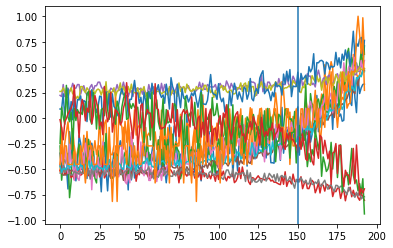

In [15]:
i = 2
plt.plot(train_FD[i][train_FD[i][0] == 25].iloc[:, 2:-1].to_numpy())
plt.axvline(x=150)
plt.show()

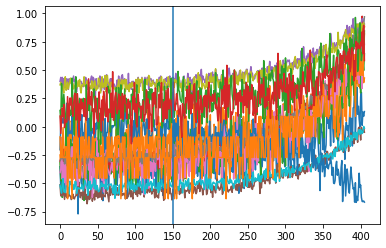

In [18]:
i = 2
plt.plot(train_FD[i][train_FD[i][0] == 9].iloc[:, 2:-1].to_numpy())
plt.axvline(x=150)
plt.show()

### Hyperparameters Declaration

In [48]:
# Data hyper-parameters:
valid_size = 0.1
window_size = 30
max_rul = 130
batch_size = 128

# Model hyper-parameters:
source_size = 14
hidden_size = 256
num_layers = 1
dropout = 0.1
bidirect = False

# Training hyper-parameters:
max_epochs = 100
lr = 1e-1
momentum = 0.9
weight_decay = 1e-4
scheduler_factor = 0.5
scheduler_patience = 20
log_train_val = 90
earlystop_patience = 100

### Dataset & DataLoader

In [55]:
# Choose dataset:
train_fd, val_fd = train_val_split([train_FD[0], train_FD[2]], valid_size)
# Prepare train/valid dataset/dataloader:
trainset, trainloader = prepare_data(train_fd, window_size, max_rul, batch_size, True, pin_memory=True)
validset, validloader = prepare_data(val_fd, window_size, max_rul, batch_size, False, pin_memory=True)

### Training Loop

In [56]:
# Initialize model:
model = SimpleGRU(source_size, hidden_size, num_layers, dropout, bidirect)
model.to(device)
# Initialize optimizer:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# Initialize learning rate scheduler:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True)
# Initialize criterion:
criterion = nn.MSELoss()

# Training history:
history = {
    'train_mse': [],
    'valid_mse': []
}

#Create trainer & evaluator:
metrics = {
    'mse': Loss(criterion),
}
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

# Log training & validation results:
@trainer.on(Events.ITERATION_COMPLETED(every=log_train_val))
def log_results(trainer):
    evaluator.run(validloader)
    s = trainer.state
    m = evaluator.state.metrics
    history['train_mse'].append(s.output)
    history['valid_mse'].append(m['mse'])
    print("Epoch [%d/%d] train_mse: %f\tval_mse: %f" \
          % (s.epoch, s.max_epochs, s.output, m['mse']), flush=True)

# Learning rate schedule:
@evaluator.on(Events.COMPLETED)
def reduce_lr_on_plateau(evaluator):
    scheduler.step(evaluator.state.metrics['mse'])
    
# Early Stopping - Tracking Validation Loss:
def score_function(engine):
    return -engine.state.metrics['mse']
earlystopper = EarlyStopping(patience=earlystop_patience, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, earlystopper)

# Model Checkpoint:
train_day = date.today().strftime("%d.%m.%y")
checkpointer = ModelCheckpoint(f'./saved_models/{train_day}', 
                               "", 
                               score_function=score_function, 
                               score_name="mse",
                               n_saved=1,
                               global_step_transform=global_step_from_engine(trainer),
                               create_dir=True, 
                               require_empty=False)
evaluator.add_event_handler(Events.COMPLETED, checkpointer, {'SimpleGRU': model})

# Run trainer
trainer.run(trainloader, max_epochs=max_epochs)

Epoch [1/100] train_mse: 0.028411	val_mse: 0.020432
Epoch [1/100] train_mse: 0.025632	val_mse: 0.019908
Epoch [1/100] train_mse: 0.024773	val_mse: 0.019929
Epoch [2/100] train_mse: 0.023618	val_mse: 0.018830
Epoch [2/100] train_mse: 0.028747	val_mse: 0.019483
Epoch [2/100] train_mse: 0.019154	val_mse: 0.019624
Epoch [3/100] train_mse: 0.016492	val_mse: 0.021802
Epoch [3/100] train_mse: 0.021980	val_mse: 0.019843
Epoch [3/100] train_mse: 0.022539	val_mse: 0.020023
Epoch [4/100] train_mse: 0.020304	val_mse: 0.019284
Epoch [4/100] train_mse: 0.029208	val_mse: 0.023677
Epoch [4/100] train_mse: 0.019826	val_mse: 0.019182
Epoch [5/100] train_mse: 0.024039	val_mse: 0.021611
Epoch [5/100] train_mse: 0.020533	val_mse: 0.020780
Epoch [5/100] train_mse: 0.018789	val_mse: 0.020978
Epoch [6/100] train_mse: 0.022078	val_mse: 0.019656
Epoch [6/100] train_mse: 0.029233	val_mse: 0.020079
Epoch [6/100] train_mse: 0.024445	val_mse: 0.018604
Epoch [7/100] train_mse: 0.022090	val_mse: 0.019154
Epoch [7/100

Epoch [50/100] train_mse: 0.011459	val_mse: 0.012923
Epoch [51/100] train_mse: 0.011960	val_mse: 0.013184
Epoch [51/100] train_mse: 0.009301	val_mse: 0.014707
Epoch [51/100] train_mse: 0.010085	val_mse: 0.012511
Epoch [52/100] train_mse: 0.007999	val_mse: 0.012774
Epoch [52/100] train_mse: 0.010158	val_mse: 0.013116
Epoch [52/100] train_mse: 0.011778	val_mse: 0.013584
Epoch [53/100] train_mse: 0.007242	val_mse: 0.013118
Epoch [53/100] train_mse: 0.008571	val_mse: 0.012628
Epoch [53/100] train_mse: 0.008539	val_mse: 0.013858
Epoch [54/100] train_mse: 0.008655	val_mse: 0.013219
Epoch [54/100] train_mse: 0.009547	val_mse: 0.013408
Epoch [54/100] train_mse: 0.011715	val_mse: 0.013618
Epoch [54/100] train_mse: 0.009666	val_mse: 0.013648
Epoch [55/100] train_mse: 0.009729	val_mse: 0.013405
Epoch [55/100] train_mse: 0.007844	val_mse: 0.012721
Epoch [55/100] train_mse: 0.008586	val_mse: 0.012578
Epoch [56/100] train_mse: 0.008986	val_mse: 0.012912
Epoch [56/100] train_mse: 0.008587	val_mse: 0.

Epoch [98/100] train_mse: 0.012489	val_mse: 0.013181
Epoch [99/100] train_mse: 0.008144	val_mse: 0.013100
Epoch [99/100] train_mse: 0.011674	val_mse: 0.012901
Epoch [99/100] train_mse: 0.008647	val_mse: 0.012966
Epoch [99/100] train_mse: 0.009076	val_mse: 0.013036
Epoch   309: reducing learning rate of group 0 to 7.8125e-04.
Epoch [100/100] train_mse: 0.008722	val_mse: 0.012839
Epoch [100/100] train_mse: 0.009108	val_mse: 0.013062
Epoch [100/100] train_mse: 0.006043	val_mse: 0.013016


State:
	iteration: 28000
	epoch: 100
	epoch_length: 280
	max_epochs: 100
	output: 0.007512672804296017
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

### Testset Evaluation

In [54]:
# Test model in all 4 test datasets:
model.load_state_dict(torch.load("./saved_models/22.07.20/simple_gru_SimpleGRU_33_mse=-0.0059226401033377115.pth"))
test(model, test_FD, rul_FD, window_size, max_rul, device)

[14.335345605537947, 89.39013244661236, 54.60082187715211, 93.7105418773726]

### Prediction on Unseen Data

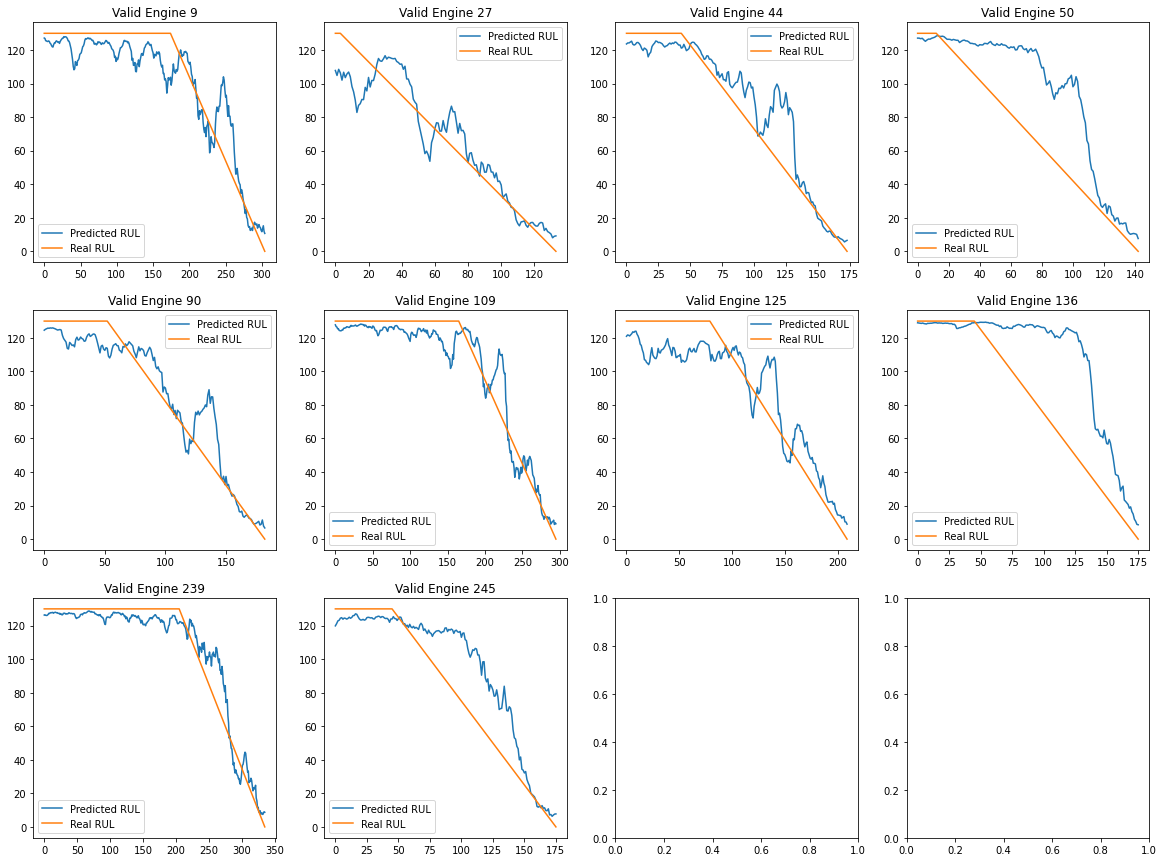

In [24]:
# Plot predicted RUL in some of the valid engines:
plot_rul(model, device, val_fd[3], max_rul, window_size, n_cols=4, figsize=(20, 15))

### Training History

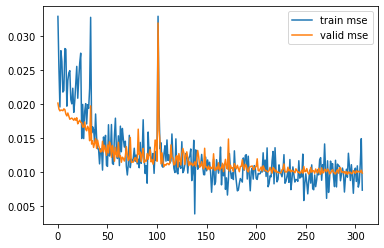

In [52]:
plt.plot(history['train_mse'], label='train mse')
plt.plot(history['valid_mse'], label='valid mse')
plt.legend()